<div class="alert">
    <h1 align="center">Language Models</h1>
    <h5 align="center"><a href="https://github.com/amirjahantab/">Amirreza Jahantab</a></h5>
</div>

## Libraries

In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from utils import *
from data_utils import Vocabulary
from train_utils import train

from IPython.core.debugger import Pdb  ## DEBUG ##

# setup
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12., 6.)
pdb = Pdb()
use_gpu = torch.cuda.is_available()

Helper functions

In [11]:
def plot_loss(trn_hist, val_hist):
    plt.plot(trn_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


def tokenize_corpus(corpus_path):
    num_lines = len(open(corpus_path, encoding='utf8').read().split('\n'))
    
    # tokenize corpus
    output = ''
    with open(corpus_path, encoding='utf8') as f:
        for line in tqdm_notebook(f, desc='Tokenizing', total=num_lines):
            tokens = tokenizer(line.strip()) + ['\n']
            output += ' '.join(tokens)
    
    # save tokenized corpus
    tok_corpus_path = corpus_path[:-4] + '_tok.txt'
    with open(tok_corpus_path, 'w', encoding='utf8') as f:
        f.write(output)

## Data

- A huge amount of texts containing bilions of words (such as all wikipedia articles).
- But here, we use a rather small corpus containing Rumi's poems (Masnavi).

In [16]:
data_dir = 'data/masnavi'
output_dir = f'{data_dir}/models'

train_data = f'{data_dir}/masnavi.txt'
train_data_tok = train_data[:-4] + '_tok.txt'

### Tokenizing

### Statistics

In [20]:
def cal_stats(corpus_path):
    # collect the number of tokens used in each sentence of the corpus in a list
    lengths = [len(s.split(' ')) for s in open(corpus_path, encoding='utf8').read().split('\n')]
    
    # compute stats
    total = sum(lengths)
    mean = np.mean(lengths)
    std = np.std(lengths)
    
    # print stats
    print('Total words in the corpus = {}\n'.format(total))
    print('Mean = {:.2f}'.format(mean))
    print('Std  = {:.2f}'.format(std))
    print('95% confidence interval = [{:.2f}, {:.2f}]'.format(mean-2*std, mean+2*std))
    
    # plot histogram
    plt.hist(lengths, bins=20)
    plt.show()

Total words in the corpus = 155267

Mean = 11.37
Std  = 3.23
95% confidence interval = [4.92, 17.82]


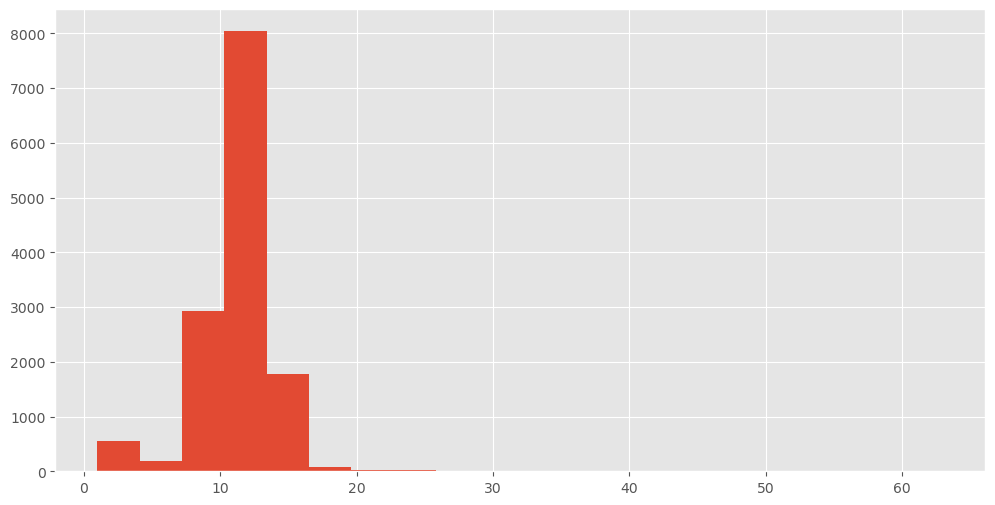

In [21]:
cal_stats(train_data)

### Corpus

In [23]:
class Corpus(object):
    
    def __init__(self, corpus_path='data/train.txt'):
        self.vocabulary = Vocabulary()
        self.corpus_path = corpus_path
        self.num_sentences = len([line for line in open(corpus_path, encoding='utf8')])
    
    def get_data(self, max_vocab=30000, min_count=3, batch_size=20, split_ratio=0.2):
        
        # First pass: add words to the vocabulary
        trn_tokens, val_tokens = [], []
        with open(self.corpus_path, encoding='utf8') as f:
            for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):
                tokens = line.split() + ['<EOS>']
                if len(line) <= 10: continue
                if random.random() < split_ratio:
                    val_tokens += tokens
                else:
                    trn_tokens += tokens
        
        counter = Counter(trn_tokens + val_tokens)
        
        # sort tokens according to their frequencies in the Corpus
        vocabs = [(w, c) for (w, c) in counter.most_common(max_vocab) if c >= min_count]
        
        for i, (word, count) in enumerate(vocabs):
            self.vocabulary.word2index[word] = i
            self.vocabulary.word2count[word] = count
            self.vocabulary.index2word[i] = word
            self.vocabulary.num_words += 1
        self.vocabulary.add_word('<UNK>')
        
        
        # Second pass: Tokenize file content
        UNK_TOKEN = self.vocabulary.word2index['<UNK>']
        
        # train ids
        trn_ids = torch.LongTensor(len(trn_tokens))
        for idx, token in enumerate(trn_tokens):
            if token in self.vocabulary.word2index:
                trn_ids[idx] = self.vocabulary.word2index[token] 
            else:
                trn_ids[idx] = UNK_TOKEN
        
        # validation ids
        val_ids = torch.LongTensor(len(val_tokens))
        for idx, token in enumerate(val_tokens):
            if token in self.vocabulary.word2index:
                val_ids[idx] = self.vocabulary.word2index[token] 
            else:
                val_ids[idx] = UNK_TOKEN
        
        num_batches = trn_ids.size(0) // batch_size
        trn_ids = trn_ids[: num_batches * batch_size]
        
        num_batches = val_ids.size(0) // batch_size
        val_ids = trn_ids[: num_batches * batch_size]

        return trn_ids.view(batch_size, -1), val_ids.view(batch_size, -1)

### Hyper-parameters

In [25]:
max_vocab = 30000
min_count = 1

# LSTM hyper-parameters
embed_size = 1500
hidden_size = 1500
num_layers = 2

# Training hyper-parameters
num_epochs = 40
batch_size = 50
seq_length = 60
learning_rate = 0.001

### Load Data

In [27]:
corpus = Corpus(train_data_tok)
trn_ids, val_ids = corpus.get_data(max_vocab, min_count, batch_size)
vocab_size = len(corpus.vocabulary)

# save vocabs and ids
pickle.dump(corpus.vocabulary, open(f'{data_dir}/vocab.pkl', 'wb'))
np.save(f'{data_dir}/trn_ids.npy', trn_ids.view(-1).numpy())
np.save(f'{data_dir}/val_ids.npy', val_ids.view(-1).numpy())

C:\Users\Amir\AppData\Local\Temp\ipykernel_2496\264560081.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):


Building Vocab...:   0%|          | 0/13655 [00:00<?, ?it/s]

In [28]:
# corpus = Corpus(train_data)
# corpus.vocabulary = pickle.load(open(f'{data_dir}/vocab.pkl', 'rb'))

# trn_ids = torch.LongTensor(np.load(f'{data_dir}/trn_ids.npy'))
# trn_ids = trn_ids[: trn_ids.size(0) // batch_size * batch_size]
# trn_ids = trn_ids.view(batch_size, -1)

# val_ids = torch.LongTensor(np.load(f'{data_dir}/val_ids.npy'))
# val_ids = val_ids[: val_ids.size(0) // batch_size * batch_size]
# val_ids = val_ids.view(batch_size, -1)

In [29]:
vocab_size = len(corpus.vocabulary)
print(vocab_size)
print(trn_ids.size())
print(val_ids.size())

18526
torch.Size([50, 2904])
torch.Size([50, 706])


In [30]:
most_commons = [(w, c) for (w, c) in corpus.vocabulary.word2count.items()][:20]

for w, c in most_commons:
    print(w, c)

<EOS> 13133
و 6623
از 4116
آن 4014
را 3924
در 3399
كه 3048
او 2273
بر 2160
اين 2033
چون 2000
ز 1980
تو 1751
به 1521
است 1503
تا 1428
اى 1200
بود 1119
من 1117
هر 1108


## LSTM For Language Modeling

In [33]:
class LSTM_LM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, drop=0.35, tie=True):
        super(LSTM_LM, self).__init__()
        
        if tie:
            embed_size = hidden_size
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
            
        self.dropout = nn.Dropout(drop)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        if tie:
            # Use the same weights both for embedding and classification
            self.fc.weight.data = self.embedding.weight.data
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def init_hidden(self, batch_size):
        return (to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)),
                to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        
    def forward(self, x, hidden):
        # embed word ids to vectors
        x = self.embedding(x)
        x = self.dropout(x)  # DROPOUT
        
        # forward RNN step
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)  # DROPOUT
        
        # reshape output to (bs * seq_length, hidden_size)
        x = x.contiguous().view(x.size(0) * x.size(1), x.size(2))
        
        # decode hidden states of all time steps
        x = self.fc(x)
        
        return x, hidden
    
    def save(self, epoch, loss, save_to=output_dir):
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        filename = output_dir + '/lm-masnavi-epoch-{}-em-{}-hi-{}-nl-{}-{:.2f}-{:.2f}.pth'.format(
            epoch, self.embed_size, self.hidden_size, self.num_layers, loss, np.exp(loss))
        torch.save(self.state_dict(), filename)

#### Tie Weights (Embedding and classification)

<h6>Idea:</h6> Reuse Embeddings for Classification, which greatly reduces the number of trainable parameters:
- [Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling (Inan et al. 2016)](https://arxiv.org/pdf/1611.01462.pdf)

### Define model

In [37]:
# model
model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, drop=0.65)
if use_gpu:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

### Training

In [39]:
hist = train(model, trn_ids, val_ids, 
             criterion, optimizer, scheduler, 
             num_epochs, batch_size, seq_length)

C:\Users\Amir\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
G:\masnavi\train_utils.py:38: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.3)


Training: Epoch [1/40], Step [48/48], Loss: 9.750, Perp: 17154.47, Acc: 0.00           

G:\masnavi\utils.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


Validation: Epoch [40/40], Step [11/11], Loss: 0.795, Perp: 2.22, Acc: 0.87             

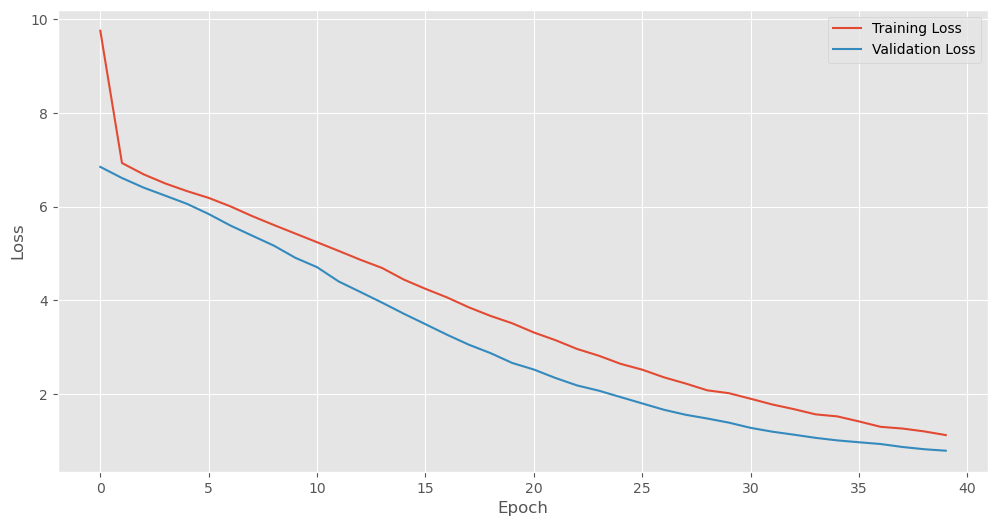

In [55]:
plot_loss(*hist)

In [56]:
torch.save(model.state_dict(), 'masnavi-lm.pth')

### Sampling

<h6>Algorithm:</h6>
1. **Initialize** the LSTM state (`h`, `c`) with zeros.

2. Pick a **random word** from vocabulary as the seed.

3. while number of generated samples is less than the desired:
 
 3.1 **Feed** the LSTM using the word generated from previous time-step.
 
 3.2 Perform **forward computations** to create the probabilty distribution vector for vocabularies.
 
 3.3 Pick a **random word** from vocabulary according to the probabilty distribution from LSTM.

In [61]:
N = 1000
p = torch.FloatTensor([0.5, 0.25, 0.15, 0.10])
# p = torch.FloatTensor([50, 25, 15, 10])

counter = Counter()

# Draw N samples
for _ in range(N):
    sample = torch.multinomial(p, num_samples=1, replacement=True)[0]
    counter[sample] += 1
    
# print samples and their counts
# for sample, count in counter.most_common():
#     print("{:d}: {:2d}".format(sample, count))

In [75]:
import torch
from tqdm.notebook import tqdm

def get_sample(model, sample_len):
    model.eval()
    sample = ''
    state = model.init_hidden(1)  # Assuming model has an `init_hidden` method

    # select a random word id to start sampling
    probs = torch.ones(vocab_size)  # Uniform distribution over vocab
    inp = torch.multinomial(probs, num_samples=1).unsqueeze(1)  # Random starting word
    inp = inp.to(next(model.parameters()).device)  # Ensure inp is on the same device as the model

    # Inference should be inside torch.no_grad() to save memory
    with torch.no_grad():
        for i in tqdm(range(sample_len)):
            output, state = model(inp, state)

            # Convert model output logits to probabilities and sample a word id
            probs = torch.softmax(output.squeeze(), dim=-1).cpu()  # Use softmax to get probabilities
            word_id = torch.multinomial(probs, 1).item()

            # Feed sampled word id to the next time step
            inp.fill_(word_id)

            # Get word from the vocabulary
            word = corpus.vocabulary.index2word.get(word_id, '<UNK>')  # Handle unknown word_ids

            # Check for end of sequence
            if word == '<EOS>':
                sample += '\n'
            else:
                sample += ' ' + word
    
    return sample


In [79]:
sample = get_sample(model, 300)
print(sample)

  0%|          | 0/300 [00:00<?, ?it/s]


 يك خرد گو اى حكيم تا نبينى از جسم ز برى‏
 اى سليمان همچو اهل مرد ناز از رنج باشد دم‏به‏دم‏
 اندر براى روح گير غور باشد چه در جهل چراست‏
 هين ابراهيم كن السلام بر بهانه‏ى و بر رقص و فاش‏
 غايت گويد بحر خوش بعد سوى تو منم آيد جان يشم‏
 قدرت بين تا چار كنى گر چنان باشد چرا واده
 گر چه زهرى در دزدد همچو دستان كرد گويد تمام‏
 گر چه واجب تا دروغ نيست گر نه آيد خون هيچ‏
 ور تو بدانى و لهو چون شهان باشد اى اقبال
 اى بلال پيش دامن سوى دل پاك معلق
 وقت راى و ثمود باز گزيند تا بود همچون
 اى جواب ده مريم سر ترك بايد و من لكم
 زين گبر بنگر سكر تا سعادت است پيدا وقت
 چون جنين زود استى تا كشند كى برهنه سوى ريختى‏
 تا برون بى‏تو سوى راه تا آخر آخر اى درون‏
 ور ناديده ماه آمدم نيست اندر تقليد كن مأمور
 هيچ كردم ز نامدند سوى نصح چون بهشت
 اى عدوى كن بهل به ترك نسيان كردن اى حسن‏
 جمله من بى‏حقيقت و خوابستم تا نيستم اى خوب پوشان
 اى حنانه ترك خودى تا خاين كرده تيغشان
 اى دروغ كرده رو رويد كز پشتم كن اينجا درون‏
 نيست كوران مى‏كند آهنگ فايده نى نداند از دغل‏
 دوزخ گيرد عرضه كاين نه عز است پنهان سخت‏
 ني

In [81]:
with open('sample.txt', 'w', encoding='utf8') as f:
    f.write(sample)

## Load a pre-trained Model

In [83]:
model = LSTM_LM(vocab_size, embed_size=1500, hidden_size=1500, num_layers=2)
model.load_state_dict(torch.load('masnavi-lm.pth'))
if use_gpu:
    model = model.cuda()

C:\Users\Amir\AppData\Local\Temp\ipykernel_2496\600167077.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('masnavi-lm.pth'))


In [85]:
sample = get_sample(model, 300)
print(sample)

  0%|          | 0/300 [00:00<?, ?it/s]

 تا ضعيف بر گزيد تا مجاز
 تا پيمبر آيد اضطرار تا نگردد عقل سوى صلاح‏
 تا همان آيد سرم راه گر دمى آيد مى‏شوى‏
 اى نشان هم بلاهاى تا مران من شده با الكلام‏
 تا نشان كردم دروغ تا سلاسل كرده بنگر نه
 من عدم كن كه داروى همچو منبل از حيل
 ور بجوشد از ولى سر تا نيفتد بر گريزند
 عاقبت باشد لأمري و غره‏ى تا صلحش كرد مار را
 ز هوا بازى مى‏دهد دست لحظه بر كشت خشك
 تا بيرون خود ذوق خويش تا يظنوا اندر ستانت
 محرمى‏ باشد مى‏زنش تا چه فردا است نه جوانا
 الدين باشد پهلوى در گر چه سست آيد نه بلى‏
 من چه بگذار نه كارت بود تا طاوس بود آن سود
 چون به او حالش شد فاش تا بر آن دل شد شرم
 باز موسى را به حق خرس او به حق سوى زنان‏
 همچو رنجور زنم ما مصحف كش گلنار و ابدانشان‏
 كافرم نه نمى‏آيد كان طرف باشد وقت بلكه
 نه نديدم تا دروگر همچو خيالى باز بنه
 اى عدوى عاصيان كردم خرند تا مزين آيد ديوانه‏وار
 كه به افسانه نه الفرح تا نگردد اين وقت جوال‏
 همچو صورت اختيار آخر كشند زين براق است زير مى‏دان
 ز احمقان كه طبق تا شود اندر نشان سود مى‏كنند
 خون شه هست حال نيست يا بايد كرد تا اله‏
 از زن پيدا كن آغاز چون كه فرعو